# Inference experiments

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path

import numpy as np
import pandas as pd
import torch
from torchmetrics.functional.text import word_error_rate
from torchmetrics.functional.text import char_error_rate
import matplotlib.pyplot as plt

from src.models.carbune_module import CarbuneLitModule2
from src.models.carbune_module import LitModule1
from src.models.components.carbune2020_net import Carbune2020NetAttempt1
from src.utils.io import load_alphabet
from src.data.tokenisers import AlphabetMapper
from src.data.online_handwriting_datamodule import IAMOnDBDataModule

TODOs:

4. Then load IAMonDB dataset and do inference. Consider using `Trainer` instead of DIY approach of doing inference. That's b/c it's easier and will not be seen in the promo video anyways.
4. Then run full training to get `checkpoint` data from there to play around.
4. Then load handwritten X++pagewise dataset and do inference on them
4. Then look for method to draw stroke in Jupyter Notebook.

*Note:* Make sure that I do correct pre-processing!

---

TODO:
- Remove other attemtps to open checkpoint
- Check if I am good to ignore CTCDecoder indeed
- tidy up code here
- try to do inference w/ 'iam_SimpleNormalise_xyn' model!

- OTHER: THINK ABOUT BEAM DECODER!

---

- Use predict step from PL instead?

In [3]:
BASE_PATH = Path('../logs/train/multiruns/2024-04-07_13-03-01/0')
CHECKPOINT_PATH = BASE_PATH / 'checkpoints/epoch000649.ckpt'

model = LitModule1.load_from_checkpoint(CHECKPOINT_PATH)

model.eval()

/localdisk/s1691089/venvs/carbune2020/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:198: Attribute 'decoder' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['decoder'])`.


LitModule1(
  (criterion): CTCLoss()
  (log_softmax): LogSoftmax(dim=2)
  (lstm_stack): LSTM(3, 64, num_layers=3, bidirectional=True)
  (linear): Linear(in_features=128, out_features=82, bias=True)
)

In [4]:
checkpoint = torch.load(CHECKPOINT_PATH, map_location=lambda storage, loc: storage)
list(checkpoint.keys())

['epoch',
 'global_step',
 'pytorch-lightning_version',
 'state_dict',
 'loops',
 'callbacks',
 'optimizer_states',
 'lr_schedulers',
 'hparams_name',
 'hyper_parameters',
 'datamodule_hparams_name',
 'datamodule_hyper_parameters']

In [5]:
alphabet = load_alphabet(BASE_PATH / 'alphabet.json')
alphabet_mapper = AlphabetMapper( alphabet )
decoder = checkpoint['hyper_parameters']['decoder']

### Load data: From IAMOnDB

In [6]:
dm = IAMOnDBDataModule(
    '../data/datasets/IAM-OnDB',
    batch_size=64,
    train_val_test_split=[0.8, 0.2, 0],
    num_workers=4,
    pin_memory=True,
    # limit=200,
    limit=-1,
    transform='iam_SimpleNormalise_xyn',
)
dm.setup()
dl_val = dm.val_dataloader()
dl_train = dm.train_dataloader()

### Do inference: IAMOnDB

In [ ]:
df_data = {
    'name': [],
    'type': [],
    'value': [],
}

for name, dloader in { 'train': dl_train, 'val': dl_val }.items():
    for sample_batched in dloader:
        batch = sample_batched # Just a shortcut

        log_softmax = model(sample_batched['ink'].to('cuda'))

        decoded_texts = decoder(log_softmax, alphabet_mapper)

        # TODO: Put this in function to use both here and in model training -> or just use underlying true data
        # TODO: Could be pre-computed (using list0 in batch to avoid endless recomputation
        labels = []
        for i_batch in range(log_softmax.shape[1]):
            label_length = batch['label_lengths'][i_batch]
            label = batch['label'][i_batch, :label_length]
            label = [ alphabet_mapper.index_to_character(c) for c in label ]
            label = "".join(label)
            labels.append(label)

        cer = char_error_rate(preds=decoded_texts, target=labels)
        wer = word_error_rate(preds=decoded_texts, target=labels)

        df_data['name'].append(name)
        df_data['type'].append('cer')
        df_data['value'].append(cer.item())

        df_data['name'].append(name)
        df_data['type'].append('wer')
        df_data['value'].append(wer.item())

df = pd.DataFrame.from_dict(df_data)

In [ ]:
df.groupby(['name', 'type']).mean()

value
name  type          
train cer   0.052492
      wer   0.235398
val   cer   0.079784
      wer   0.316895

Reloading seems to work!

Strangely, the `train` values change (both cer and wer) when re-executing but not the `val` values. Question: also when re-executing the cell?

### Load data: From XournalPagewise

In [ ]:
dm_xp = IAMOnDBDataModule(
    '../data/datasets/2024-02-16-xournal_dataset.xoj',
    batch_size=64,
    train_val_test_split=[1.0, 0.0, 0],
    num_workers=4,
    pin_memory=True,
    # limit=200,
    limit=-1,
    transform='XournalPagewise_SimpleNormalise_xyn',
)
dm_xp.setup()
dl_val_xp = dm_xp.val_dataloader()
dl_train_xp = dm_xp.train_dataloader()

/localdisk/s1691089/venvs/carbune2020/lib/python3.10/site-packages/torch/utils/data/dataset.py:414: UserWarning: Length of split at index 1 is 0. This might result in an empty dataset.
  warnings.warn(f"Length of split at index {i} is 0. "
/localdisk/s1691089/venvs/carbune2020/lib/python3.10/site-packages/torch/utils/data/dataset.py:414: UserWarning: Length of split at index 2 is 0. This might result in an empty dataset.
  warnings.warn(f"Length of split at index {i} is 0. "


### Do inference: XournalPagewise

In [ ]:
df_data = {
    'name': [],
    'type': [],
    'value': [],
}

for name, dloader in { 'train': dl_train_xp, 'val': dl_val_xp }.items():
    for sample_batched in dloader:
        batch = sample_batched # Just a shortcut

        log_softmax = model(sample_batched['ink'].to('cuda'))

        decoded_texts = decoder(log_softmax, alphabet_mapper)

        # TODO: Put this in function to use both here and in model training -> or just use underlying true data
        # TODO: Could be pre-computed (using list0 in batch to avoid endless recomputation
        labels = []
        for i_batch in range(log_softmax.shape[1]):
            label_length = batch['label_lengths'][i_batch]
            label = batch['label'][i_batch, :label_length]
            label = [ alphabet_mapper.index_to_character(c) for c in label ]
            label = "".join(label)
            labels.append(label)

        cer = char_error_rate(preds=decoded_texts, target=labels)
        wer = word_error_rate(preds=decoded_texts, target=labels)

        df_data['name'].append(name)
        df_data['type'].append('cer')
        df_data['value'].append(cer.item())

        df_data['name'].append(name)
        df_data['type'].append('wer')
        df_data['value'].append(wer.item())

df = pd.DataFrame.from_dict(df_data)

In [ ]:
df.groupby(['name', 'type']).mean()

value
name  type          
train cer   1.038462
      wer   1.400000

Why is this not working?!

## Hypothesis: The two datasets are very different and hence the performance on X++ is so bad

Investigate the lengths of the differences:

In [ ]:
def get_segment_lengths(dataloaders: list) -> list:
    results = []

    for dataloader in dataloaders:
        for sample in dataloader:
            batch_size = sample['ink'].shape[1]
            for i_sample_in_batch in range(batch_size):
                length = sample['ink_lengths'][i_sample_in_batch]
                dx, dy = sample['ink'][:length, i_sample_in_batch, [0, 1]].T
                segment_lengths = np.sqrt((dx**2 + dy**2))
                results += segment_lengths.tolist()

    return np.array(results)

In [ ]:
segment_lengths_IAM = get_segment_lengths([dl_train, dl_val])
segment_lengths_Xpp = get_segment_lengths([dl_train_xp, dl_val_xp])

len(segment_lengths_IAM), len(segment_lengths_Xpp)

(7651716, 1771)

In [ ]:
for sl in [segment_lengths_Xpp, segment_lengths_IAM]:
    print(sl.mean(), sl.std(), sl.max(), np.quantile(sl, 0.5), np.quantile(sl, 0.98))

0.03075740663339986 0.0582288076165338 0.8580945730209351 0.02013082057237625 0.10204081982374191
0.04772649997899526 0.08719070655718524 6.154927730560303 0.03245917335152626 0.3021262019872666


In [ ]:
segment_lengths_IAM_filtered = segment_lengths_IAM[ segment_lengths_IAM <= np.quantile(segment_lengths_IAM, 0.98) ]
segment_lengths_Xpp_filtered = segment_lengths_Xpp[ segment_lengths_Xpp <= np.quantile(segment_lengths_Xpp, 0.98) ]

for sl in [segment_lengths_Xpp_filtered, segment_lengths_IAM_filtered]:
    print(sl.mean(), sl.std(), sl.max(), np.quantile(sl, 0.5), np.quantile(sl, 0.98))

0.02406824852955798 0.016340708112571444 0.10204081982374191 0.02013082057237625 0.06732454672455779
0.037394472426955434 0.0322870289407739 0.3021261394023895 0.03190260007977486 0.11745930761098834


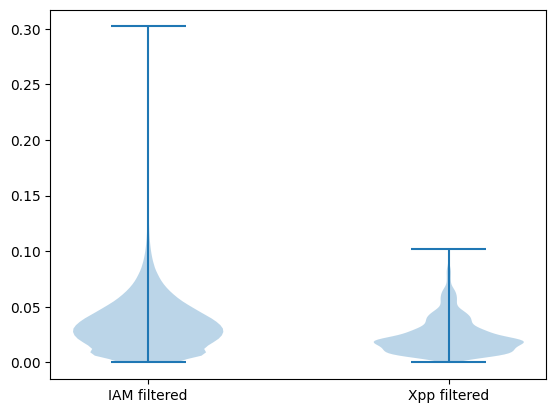

In [ ]:
plt.figure()
plt.violinplot([segment_lengths_IAM_filtered, segment_lengths_Xpp_filtered])
plt.xticks(ticks=[1, 2], labels=['IAM filtered', 'Xpp filtered'])
plt.show()

The distributions do look quite different. This observation strenghtens my hypothesis that the segment lengths are just too different for the model to cope with.

TODO NEXT: Idea to check if the distributions are the problem:
1. Check distributions of IAM and X++ after applying Carbune2020.
2. Then train model on IAM with applied Carbune and then do inference w/ Xpp.

AHHH, problem with that is that my X++ does not have time channel and that `Carbune2020` trafo depends on time :-(. Potential solutions:
- maybe find way to capture my handwriting w/ time channel.

## Load and experiment w/ `Own_Dataset`

In [18]:
from src.data.online_handwriting_datasets import Own_Dataset
from src.data.online_handwriting_datasets import IAM_OnDB_Dataset

In [16]:
o_ds = Own_Dataset(Path('../data/datasets/own_test_dataset'), transform=None)

In [19]:
ds = IAM_OnDB_Dataset(Path('../data/datasets/IAM-OnDB'))

Plot one sample to confirm that my own test dataset is using correct axes:
(TODO: PUT THAT INTO A TEST!)

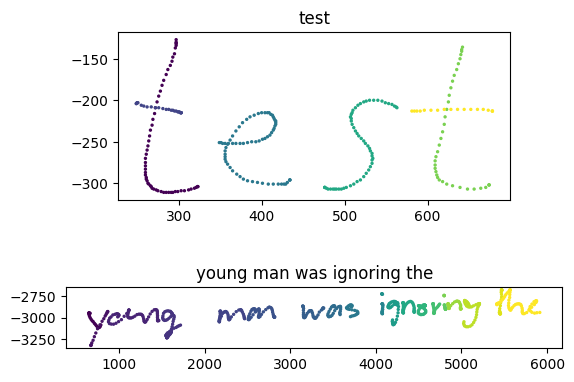

In [39]:
i_o_ds = 1
i_iam = 32

fig, axes = plt.subplots(2, 1)

axes[0].scatter(o_ds[i_o_ds]['x'], o_ds[i_o_ds]['y'], c=o_ds[i_o_ds]['stroke_nr'], s=2)
axes[1].scatter(ds[i_iam]['x'], ds[i_iam]['y'], c=ds[i_iam]['stroke_nr'], s=2)

axes[0].set_title(o_ds[i_o_ds]['label'])
axes[1].set_title(ds[i_iam]['label'])

for a in axes:
    a.set_aspect('equal')

plt.show()

*Result*: My own dataset and `draw_and_store_sample.py` script saves the data correctly!

TODO: Move this into a test using `plot_sample_to_image_file` and manual inspection.